# Alphavirus RdRp conservation Analysis

# Direct Coupling Analysis (DCA), direct information (DI)

Traditional covariance methods can identify correlated variables (like amino acid residues in proteins that change together) but can't differentiate if these correlations are direct (two variables directly influencing each other) or indirect (their correlation is due to both being influenced by a third variable).  

DCA goes beyond traditional covariance methods by attempting to infer direct interactions between variables (e.g., amino acid residues in a protein) from large multiple sequence alignments (MSAs). The output of DCA includes scores for pairs of positions in a sequence, indicating the strength and likelihood that they interact directly, rather than merely appearing to interact due to indirect effects mediated by other positions.  

### How DCA Works
**Multiple Sequence Alignment**: DCA begins with an MSA, which aligns sequences from similar proteins across different species or variants. This alignment helps identify conserved and variable positions across sequences.    

**Covariance Calculation**: DCA calculates the covariance for each pair of positions in the MSA. High covariance suggests that changes in one position often coincide with changes in another, which might indicate some form of interaction.    

**Inferring Direct Interactions**:
Unlike simpler covariance methods, DCA uses statistical models to differentiate direct interactions from indirect correlations.
The model assigns a score to each possible pair of residues, with higher scores indicating a stronger likelihood of direct interaction.   

**Inversion of the Covariance Matrix**: One approach within DCA involves inverting the covariance matrix of the alignment to extract direct information, which helps in separating direct from indirect interactions.

https://www.pnas.org/doi/full/10.1073/pnas.0805923106

In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import Entrez, SeqIO, AlignIO
from Bio.PDB import PDBParser, PDBIO, Chain

import ast

pd.set_option('display.max_columns', 110)

In [2]:
def Zscore(column_val):
    m = np.mean(column_val)
    std = np.std(column_val)
    zscore = [((x - m)/std) for x in column_val]
    return zscore

## Covariance analysis on nsP4 - Compact Conformation

In [3]:
cov = pd.read_csv('../results/DCA/nsP4/v02/PLMDCA_FN_APC_nsp4-RdRp-compact_seqIdt0.85_lh1_lj20.txt', sep='\t')
cov['Tuple'] =  cov.apply(lambda row: (int(row['first_site']), int(row['second_site'])), axis=1)
cov = cov[['first_site', 'second_site', 'Tuple', 'APC']]
cov['Zscore'] = Zscore(cov['APC'])
cov

,first_site,second_site,Tuple,APC,Zscore
0,154,156,"(154, 156)",0.042384,6.986669
1,240,473,"(240, 473)",0.042111,6.941600
2,75,216,"(75, 216)",0.041125,6.779003
3,89,496,"(89, 496)",0.038878,6.408639
4,103,240,"(103, 240)",0.038817,6.398603
...,...,...,...,...,...
186350,48,56,"(48, 56)",-0.017079,-2.816056
186351,156,510,"(156, 510)",-0.017118,-2.822533
186352,48,522,"(48, 522)",-0.017196,-2.835364
186353,76,589,"(76, 589)",-0.018060,-2.977853


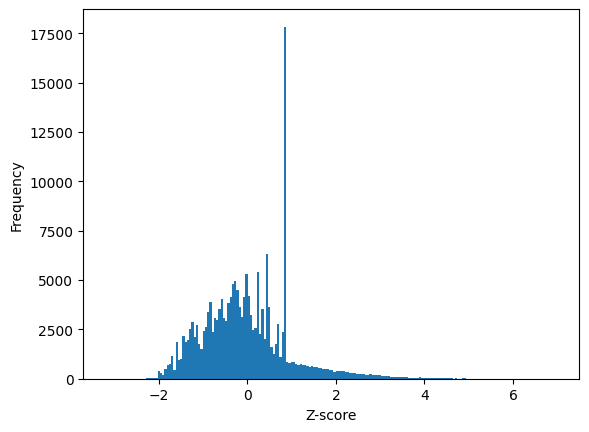

In [4]:
cov['Zscore'].plot(kind='hist', bins=200)
plt.xlabel('Z-score')
#plt.savefig('results/alphavirus/DCA/mfdca_nsp4_compact_Zscore_hist.png')
plt.show()

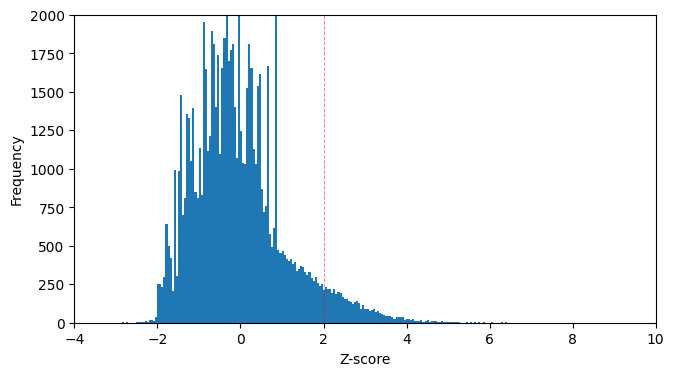

In [ ]:
cov_comp_Nter = cov.query("first_site <=150 or second_site <= 150")

plt.figure(figsize=(7.5, 4))
cov_comp_Nter['Zscore'].plot(kind='hist', bins=200)
plt.xlabel('Z-score')
plt.xlim(-4,10)
plt.ylim(-0,3000)
plt.vlines(2, 0, 3000, color='red', linestyle='--', linewidth=0.7, alpha=0.5)
#plt.savefig('results/DCA/nsP4/v02/mfdca_nsp4_Nterm_extended_Zscore_hist.png', dpi=600, bbox_inches='tight')
plt.show()

## Adding Neff

In [7]:
# neff v02 is from psiblast alignment
neff = pd.read_excel('../results/Neff/nsP4/nsp4_compact_Neff_psiblast_mapped.xlsx')

In [8]:
df1 = cov_comp_Nter.merge(neff, left_on='first_site', right_on='residue', how='left')
df1.rename(columns={'Neff': 'first_site_Neff', 'residueName':'first_site_residue'}, inplace=True)
df1 = df1[['first_site_residue','first_site','first_site_Neff', 'second_site', 'Tuple', 'APC', 'Zscore',]]
df2 = df1.merge(neff, left_on='second_site', right_on='residue', how='left')
df2.rename(columns={'Neff': 'second_site_Neff', 'residueName':'second_site_residue'}, inplace=True)

cov_comp_Nter_neff = df2[['first_site_residue', 'first_site', 'first_site_Neff',
                            'second_site_residue', 'second_site', 'second_site_Neff',
                            'Tuple', 'APC', 'Zscore',]].copy()

cov_comp_Nter_neff['Tuple'] = cov_comp_Nter_neff['Tuple'].astype(str)
cov_comp_Nter_neff

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore
0,Met,75,4.808267,Pro,216,1.000000,"(75, 216)",0.041125,6.779003
1,Ala,89,4.551939,Ala,496,1.268383,"(89, 496)",0.038878,6.408639
2,Pro,103,1.114821,Glu,240,2.289969,"(103, 240)",0.038817,6.398603
3,Ser,57,1.867111,Asn,60,1.000000,"(57, 60)",0.038609,6.364357
4,Pro,109,3.219013,Thr,588,1.022564,"(109, 588)",0.038321,6.316812
...,...,...,...,...,...,...,...,...,...
80780,Glu,32,3.073293,Ile,510,1.215954,"(32, 510)",-0.016632,-2.742413
80781,Leu,48,1.148529,Ala,56,1.872983,"(48, 56)",-0.017079,-2.816056
80782,Leu,48,1.148529,Val,522,1.103899,"(48, 522)",-0.017196,-2.835364
80783,Ile,76,2.130973,Phe,589,1.989551,"(76, 589)",-0.018060,-2.977853


### Adding distance in Å

In [9]:
compact_contact = pd.read_table('../results/Distance/nsP4/nsp4-RdRp_compact_distance_Nter150.txt')

cols=['Contact',	'Residue1_Name',	'Residue1_Pos',	'Residue2_Name',	'Residue2_Pos',	'Pairs',]
df = cov_comp_Nter_neff.merge(compact_contact, left_on='Tuple', right_on='Pairs', how='inner').drop(cols, axis=1)
df

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore,Distance(Å)
0,Met,75,4.808267,Pro,216,1.000000,"(75, 216)",0.041125,6.779003,48.64
1,Ala,89,4.551939,Ala,496,1.268383,"(89, 496)",0.038878,6.408639,48.89
2,Pro,103,1.114821,Glu,240,2.289969,"(103, 240)",0.038817,6.398603,30.77
3,Ser,57,1.867111,Asn,60,1.000000,"(57, 60)",0.038609,6.364357,6.33
4,Pro,109,3.219013,Thr,588,1.022564,"(109, 588)",0.038321,6.316812,18.18
...,...,...,...,...,...,...,...,...,...,...
80170,Glu,32,3.073293,Ile,510,1.215954,"(32, 510)",-0.016632,-2.742413,31.35
80171,Leu,48,1.148529,Ala,56,1.872983,"(48, 56)",-0.017079,-2.816056,11.12
80172,Leu,48,1.148529,Val,522,1.103899,"(48, 522)",-0.017196,-2.835364,47.94
80173,Ile,76,2.130973,Phe,589,1.989551,"(76, 589)",-0.018060,-2.977853,43.47


### Adding RSA

In [10]:
compact_rASA = pd.read_excel('../results/RSA/nsp4_RSA_compact.xlsx', index_col=0)
compact_rASA.rename(columns={'rASA_compact': 'rASA'}, inplace=True)
compact_rASA

,Residue,position,rASA
0,Y,1,0.638783
1,I,2,0.233503
2,F,3,0.258333
3,S,4,0.212903
4,S,5,0.180645
...,...,...,...
606,Y,607,0.334601
607,G,608,0.259615
608,G,609,0.423077
609,P,610,0.911950


In [11]:
mapping = {k:v for k, v in zip(compact_rASA['position'], compact_rASA['rASA'])}

df['first_site_RSA'] = [mapping[x] for x in df['first_site']]
df['second_site_RSA'] = [mapping[x] for x in df['second_site']]

cols =['first_site_residue', 'first_site', 'first_site_Neff','first_site_RSA',
       'second_site_residue', 'second_site', 'second_site_Neff',  'second_site_RSA',
       'Tuple', 'APC', 'Zscore', 'Distance(Å)', ].copy()

df2 = df[cols].copy()
df2

,first_site_residue,first_site,first_site_Neff,first_site_RSA,second_site_residue,second_site,second_site_Neff,second_site_RSA,Tuple,APC,Zscore,Distance(Å)
0,Met,75,4.808267,0.285714,Pro,216,1.000000,0.421384,"(75, 216)",0.041125,6.779003,48.64
1,Ala,89,4.551939,0.232558,Ala,496,1.268383,0.000000,"(89, 496)",0.038878,6.408639,48.89
2,Pro,103,1.114821,0.157233,Glu,240,2.289969,0.417040,"(103, 240)",0.038817,6.398603,30.77
3,Ser,57,1.867111,0.419355,Asn,60,1.000000,0.133333,"(57, 60)",0.038609,6.364357,6.33
4,Pro,109,3.219013,0.553459,Thr,588,1.022564,0.000000,"(109, 588)",0.038321,6.316812,18.18
...,...,...,...,...,...,...,...,...,...,...,...,...
80170,Glu,32,3.073293,0.479821,Ile,510,1.215954,0.025381,"(32, 510)",-0.016632,-2.742413,31.35
80171,Leu,48,1.148529,0.054726,Ala,56,1.872983,0.496124,"(48, 56)",-0.017079,-2.816056,11.12
80172,Leu,48,1.148529,0.054726,Val,522,1.103899,0.028736,"(48, 522)",-0.017196,-2.835364,47.94
80173,Ile,76,2.130973,0.005076,Phe,589,1.989551,0.000000,"(76, 589)",-0.018060,-2.977853,43.47


In [12]:
df2['abs_diff_RSA'] = df2.apply(lambda row: abs(row['first_site_RSA'] - row['second_site_RSA']), axis=1)
df2.drop(['Tuple', 'APC'], axis=1, inplace=True)
df2

,first_site_residue,first_site,first_site_Neff,first_site_RSA,second_site_residue,second_site,second_site_Neff,second_site_RSA,Zscore,Distance(Å),abs_diff_RSA
0,Met,75,4.808267,0.285714,Pro,216,1.000000,0.421384,6.779003,48.64,0.135669
1,Ala,89,4.551939,0.232558,Ala,496,1.268383,0.000000,6.408639,48.89,0.232558
2,Pro,103,1.114821,0.157233,Glu,240,2.289969,0.417040,6.398603,30.77,0.259808
3,Ser,57,1.867111,0.419355,Asn,60,1.000000,0.133333,6.364357,6.33,0.286022
4,Pro,109,3.219013,0.553459,Thr,588,1.022564,0.000000,6.316812,18.18,0.553459
...,...,...,...,...,...,...,...,...,...,...,...
80170,Glu,32,3.073293,0.479821,Ile,510,1.215954,0.025381,-2.742413,31.35,0.454440
80171,Leu,48,1.148529,0.054726,Ala,56,1.872983,0.496124,-2.816056,11.12,0.441398
80172,Leu,48,1.148529,0.054726,Val,522,1.103899,0.028736,-2.835364,47.94,0.025991
80173,Ile,76,2.130973,0.005076,Phe,589,1.989551,0.000000,-2.977853,43.47,0.005076


In [13]:
#df2.to_csv('../results/DCA/nsP4/v02/res_nsp4_compact_Neff_RSA_APC_Zscore_Dist_Nter.csv', index=False)
df2.to_excel('../results/DCA/nsP4/v02/res_nsp4_compact_Neff_RSA_APC_Zscore_Dist_Nter150.xlsx')

In [14]:
stop

NameError: name 'stop' is not defined

## Contacts of SOI

In [ ]:
# compact_cont = pd.read_excel('../results/Neff/nsP4/nsp4_compact_SOI_neff.xlsx')
# compact_cont = compact_cont[~compact_cont['nsp4'].str.contains('nsp1')]
# compact_cont['nsp4-Nter'].str.split('-').str[1]
# compact_cont['contact_pairs'] = [x for x in zip(compact_cont['nsp4-Nter'].str.split('-').str[1].astype(int), compact_cont['nsp4'].str.split('-').str[1].astype(int))]
# print(compact_cont.shape)
# compact_cont

In [ ]:
# N-TER                   Compact_nsP4
# Thr-20                  Thr-101   
# Glu-29                  His-31                 
# Val-30                  Arg-99, Arg-332                                                             
# His-31                  Glu-29   
# Cys-35                  Thr-255, Thr-258              
# Pro-37                  Thr-254                
# Pro-38                  Ile-77, Glu-70              
# Glu-70                  Pro-38, Arg-67             
# Lys-73                  Val-69
# Ile-76                  Val-257, Leu-268 
# Ile-77                  Val-257, Leu-253
# Leu-80                  Val-257, Leu-253, Tyr-322 
# Lys-81                  Thr-250 
# Cys-84                  Leu-253, Leu-278                

In [ ]:
pairs = [
    (20, 101), 
    (29, 31),  
    (30, 99), (30, 332),                                                             
    (31, 29),  
    (35, 255), (35, 258),              
    (37, 254),  
    (38, 77), (38, 70),              
    (70, 38), (70, 67),             
    (73, 69), 
    (76, 257), (76, 268), 
    (77, 257), (77, 253),
    (80, 257), (80, 253), (80, 322), 
    (81, 250),  
    (84, 253), (84, 278),
]   



In [ ]:
#pairs = list(str(compact_cont['contact_pairs'].values))
pairs = [str(x) for x in pairs]
#pairs = [str(x) for x in compact_cont['contact_pairs'].values]
res = df2.query('Tuple in @pairs')
res = res.sort_values('first_site')
res

,first_site_residue,first_site,first_site_Neff,first_site_RSA,second_site_residue,second_site,second_site_Neff,second_site_RSA,Tuple,APC,Zscore,Distance(Å)
26894,Thr,20,4.197054,0.174419,Thr,101,3.534660,0.104651,"(20, 101)",-0.001064,-0.176028,6.12
2241,Glu,29,3.290982,0.286996,His,31,3.652468,0.553571,"(29, 31)",0.014667,2.417368,5.49
740,Val,30,4.257909,0.080460,Arg,99,3.108927,0.215328,"(30, 99)",0.019599,3.230404,6.11
54718,Val,30,4.257909,0.080460,Arg,332,1.000000,0.222628,"(30, 332)",-0.010472,-1.726849,8.26
19584,Cys,35,5.424846,0.173653,Thr,258,1.692398,0.151163,"(35, 258)",0.001348,0.221627,7.73
42317,Cys,35,5.424846,0.173653,Thr,255,3.370633,0.220930,"(35, 255)",-0.005214,-0.860060,5.84
41666,Pro,37,2.216466,0.515723,Thr,254,2.494927,0.058140,"(37, 254)",-0.005146,-0.848901,6.86
48194,Pro,38,1.131964,0.150943,Glu,70,1.146002,0.233184,"(38, 70)",-0.007417,-1.223296,5.76
4179,Pro,38,1.131964,0.150943,Ile,77,3.144304,0.106599,"(38, 77)",0.011152,1.837828,8.99
8757,Ile,76,2.130973,0.005076,Leu,268,1.135277,0.283582,"(76, 268)",0.005991,0.987061,7.77


In [ ]:
# sites = [20, 21, 25, 26, 28, 29, 30, 31, 33, 35, 37, 38, 70, 73, 76, 77, 80, 81, 84, 85, 90]

# df2.query('(first_site in @sites | second_site in @sites) & Zscore > 2.0 & `Distance(Å)` < 10')#['Tuple']

In [ ]:
res.to_excel('../results/DCA/nsP4/v02/res_nsp4_compact_SOI_Neff_RSA_APC_Zscore_Dist_Nter_v02.xlsx', index=False)

In [ ]:
stop

NameError: name 'stop' is not defined

# Covariance analysis on nsP4 - Extended LUO Conformation

In [3]:
cov = pd.read_csv('../results/DCA/nsP4/v02/PLMDCA_FN_APC_nsp4-RdRp-extended_LUO_seqIdt0.85_lh1_lj20.txt', sep='\t')
cov['Tuple'] =  cov.apply(lambda row: (int(row['first_site']), int(row['second_site'])), axis=1)
cov = cov[['first_site', 'second_site', 'Tuple', 'APC']]
cov

,first_site,second_site,Tuple,APC
0,154,156,"(154, 156)",0.042384
1,240,473,"(240, 473)",0.042111
2,75,216,"(75, 216)",0.041125
3,89,496,"(89, 496)",0.038877
4,103,240,"(103, 240)",0.038816
...,...,...,...,...
186350,48,56,"(48, 56)",-0.017077
186351,156,510,"(156, 510)",-0.017118
186352,48,522,"(48, 522)",-0.017196
186353,76,589,"(76, 589)",-0.018062


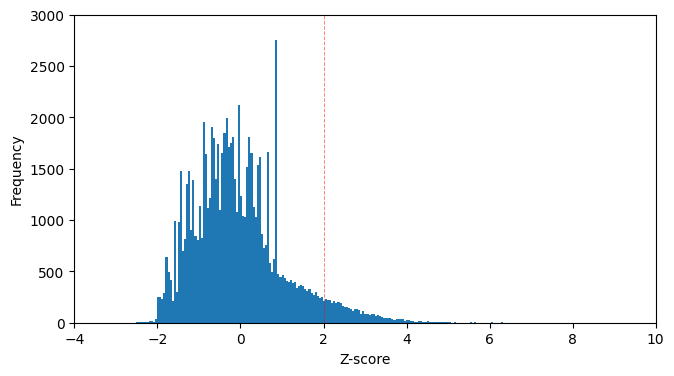

In [4]:
cov['Zscore'] = Zscore(cov['APC'])

cov_ext_Nter = cov.query("first_site <=150 or second_site <= 150")

plt.figure(figsize=(7.5, 4))
cov_ext_Nter['Zscore'].plot(kind='hist', bins=200)
plt.xlabel('Z-score')
plt.xlim(-4,10)
plt.ylim(-0,3000)
plt.vlines(2, 0, 3000, color='red', linestyle='--', linewidth=0.7, alpha=0.5)
#plt.savefig('../results/DCA/nsP4/v02/plmdca_nsp4_Nterm_extended_Zscore_hist.png', dpi=600, bbox_inches='tight')
plt.show()

## Adding Neff

In [5]:
neff = pd.read_excel('../results/Neff/nsP4/nsp4_extended_LUO_Neff_psiblast_mapped.xlsx')

df1 = cov_ext_Nter.merge(neff, left_on='first_site', right_on='residue', how='left')
df1.rename(columns={'Neff': 'first_site_Neff', 'residueName':'first_site_residue'}, inplace=True)
df1 = df1[['first_site_residue','first_site','first_site_Neff', 'second_site', 'Tuple', 'APC', 'Zscore',]]
df2 = df1.merge(neff, left_on='second_site', right_on='residue', how='left')
df2.rename(columns={'Neff': 'second_site_Neff', 'residueName':'second_site_residue'}, inplace=True)

cov_ext_Nter_neff = df2[['first_site_residue', 'first_site', 'first_site_Neff',
                            'second_site_residue', 'second_site', 'second_site_Neff',
                            'Tuple', 'APC', 'Zscore',]].copy()

#cov_ext_Nter_neff = cov_ext_Nter_neff.query("Zscore > 2")
cov_ext_Nter_neff['Tuple'] = cov_ext_Nter_neff['Tuple'].astype(str) 
cov_ext_Nter_neff

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore
0,Met,75,4.808267,Pro,216,1.000000,"(75, 216)",0.041125,6.779000
1,Ala,89,4.551939,Ala,496,1.268383,"(89, 496)",0.038877,6.408405
2,Pro,103,1.114821,Glu,240,2.289969,"(103, 240)",0.038816,6.398358
3,Ser,57,1.867111,Asn,60,1.000000,"(57, 60)",0.038609,6.364198
4,Pro,109,3.219013,Thr,588,1.022564,"(109, 588)",0.038324,6.317295
...,...,...,...,...,...,...,...,...,...
80780,Glu,32,3.073293,Ile,510,1.215954,"(32, 510)",-0.016632,-2.742414
80781,Leu,48,1.148529,Ala,56,1.872983,"(48, 56)",-0.017077,-2.815829
80782,Leu,48,1.148529,Val,522,1.103899,"(48, 522)",-0.017196,-2.835438
80783,Ile,76,2.130973,Phe,589,1.989551,"(76, 589)",-0.018062,-2.978159


### Adding distance in Å

In [6]:
#extended_contact = pd.read_table('../results/Distance/nsP4/nsp4-SAXS-extended-conf-MDsimulated_V25E91_LUO_distance.txt')
extended_contact = pd.read_table('../results/Distance/nsP4/nsp4-SAXS-extended-conf-MDsimulated_V25E91_LUO_distance_Nter150.txt')
cols=['Contact',	'Residue1_Name',	'Residue1_Pos',	'Residue2_Name',	'Residue2_Pos',	'Pairs',]
df = cov_ext_Nter_neff.merge(extended_contact, left_on='Tuple', right_on='Pairs', how='inner').drop(cols, axis=1)
df

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore,Distance(Å)
0,Met,75,4.808267,Pro,216,1.000000,"(75, 216)",0.041125,6.779000,23.37
1,Ala,89,4.551939,Ala,496,1.268383,"(89, 496)",0.038877,6.408405,49.80
2,Pro,103,1.114821,Glu,240,2.289969,"(103, 240)",0.038816,6.398358,29.77
3,Ser,57,1.867111,Asn,60,1.000000,"(57, 60)",0.038609,6.364198,6.19
4,Pro,109,3.219013,Thr,588,1.022564,"(109, 588)",0.038324,6.317295,19.04
...,...,...,...,...,...,...,...,...,...,...
80170,Glu,32,3.073293,Ile,510,1.215954,"(32, 510)",-0.016632,-2.742414,26.54
80171,Leu,48,1.148529,Ala,56,1.872983,"(48, 56)",-0.017077,-2.815829,10.97
80172,Leu,48,1.148529,Val,522,1.103899,"(48, 522)",-0.017196,-2.835438,54.47
80173,Ile,76,2.130973,Phe,589,1.989551,"(76, 589)",-0.018062,-2.978159,61.98


### Adding rASA

In [7]:
extended_rASA = pd.read_excel('../results/RSA/nsp4_RSA_MD_V25E91_LUO.xlsx', index_col=0)
extended_rASA.rename(columns={'rASA_extended': 'rASA'}, inplace=True)
extended_rASA

,Residue,position,rASA
0,Y,1,0.547529
1,I,2,0.131980
2,F,3,0.137500
3,S,4,0.083871
4,S,5,0.167742
...,...,...,...
606,Y,607,0.030418
607,G,608,0.346154
608,G,609,0.480769
609,P,610,0.817610


In [8]:
mapping = {k:v for k, v in zip(extended_rASA['position'], extended_rASA['rASA'])}


df['first_site_RSA'] = [mapping[x] for x in df['first_site']]
df['second_site_RSA'] = [mapping[x] for x in df['second_site']]

cols =['first_site_residue', 'first_site', 'first_site_Neff','first_site_RSA',
       'second_site_residue', 'second_site', 'second_site_Neff',  'second_site_RSA',
       'Tuple', 'APC', 'Zscore', 'Distance(Å)', ].copy()

df2 = df[cols].copy()
df2

,first_site_residue,first_site,first_site_Neff,first_site_RSA,second_site_residue,second_site,second_site_Neff,second_site_RSA,Tuple,APC,Zscore,Distance(Å)
0,Met,75,4.808267,0.566964,Pro,216,1.000000,0.509434,"(75, 216)",0.041125,6.779000,23.37
1,Ala,89,4.551939,0.441860,Ala,496,1.268383,0.015504,"(89, 496)",0.038877,6.408405,49.80
2,Pro,103,1.114821,0.314465,Glu,240,2.289969,0.156951,"(103, 240)",0.038816,6.398358,29.77
3,Ser,57,1.867111,0.406452,Asn,60,1.000000,0.030769,"(57, 60)",0.038609,6.364198,6.19
4,Pro,109,3.219013,0.597484,Thr,588,1.022564,0.000000,"(109, 588)",0.038324,6.317295,19.04
...,...,...,...,...,...,...,...,...,...,...,...,...
80170,Glu,32,3.073293,0.452915,Ile,510,1.215954,0.000000,"(32, 510)",-0.016632,-2.742414,26.54
80171,Leu,48,1.148529,0.114428,Ala,56,1.872983,0.697674,"(48, 56)",-0.017077,-2.815829,10.97
80172,Leu,48,1.148529,0.114428,Val,522,1.103899,0.000000,"(48, 522)",-0.017196,-2.835438,54.47
80173,Ile,76,2.130973,0.274112,Phe,589,1.989551,0.000000,"(76, 589)",-0.018062,-2.978159,61.98


In [9]:
# sites = [20, 21, 25, 26, 28, 29, 30, 31, 33, 35, 37, 38, 70, 73, 76, 77, 80, 81, 84, 85, 90]

# df2.query('(first_site in @sites | second_site in @sites) & (Zscore > 2.0 & `Distance(Å)` < 10)')#['Tuple']
df2['abs_diff_RSA'] = df2.apply(lambda row: abs(row['first_site_RSA'] - row['second_site_RSA']), axis=1)
df2.drop(['Tuple', 'APC'], axis=1, inplace=True)
df2

,first_site_residue,first_site,first_site_Neff,first_site_RSA,second_site_residue,second_site,second_site_Neff,second_site_RSA,Zscore,Distance(Å),abs_diff_RSA
0,Met,75,4.808267,0.566964,Pro,216,1.000000,0.509434,6.779000,23.37,0.057530
1,Ala,89,4.551939,0.441860,Ala,496,1.268383,0.015504,6.408405,49.80,0.426357
2,Pro,103,1.114821,0.314465,Glu,240,2.289969,0.156951,6.398358,29.77,0.157515
3,Ser,57,1.867111,0.406452,Asn,60,1.000000,0.030769,6.364198,6.19,0.375682
4,Pro,109,3.219013,0.597484,Thr,588,1.022564,0.000000,6.317295,19.04,0.597484
...,...,...,...,...,...,...,...,...,...,...,...
80170,Glu,32,3.073293,0.452915,Ile,510,1.215954,0.000000,-2.742414,26.54,0.452915
80171,Leu,48,1.148529,0.114428,Ala,56,1.872983,0.697674,-2.815829,10.97,0.583247
80172,Leu,48,1.148529,0.114428,Val,522,1.103899,0.000000,-2.835438,54.47,0.114428
80173,Ile,76,2.130973,0.274112,Phe,589,1.989551,0.000000,-2.978159,61.98,0.274112


In [10]:
#df2.to_csv('../results/DCA/nsP4/v02/res_nsp4_extended_LUO_Neff_RSA_APC_Zscore_Dist_Nter.csv', index=False)
df2.to_excel('../results/DCA/nsP4/v02/res_nsp4_extended_LUO_Neff_RSA_APC_Zscore_Dist_Nter150.xlsx')

In [11]:
stop

NameError: name 'stop' is not defined

## Contacts of SOI

In [ ]:
# ext_cont = pd.read_excel('../results/Neff/nsP4/nsp4_extended_LUO_SOI_neff.xlsx')
# ext_cont = ext_cont[~ext_cont['nsp4'].isna()]
# ext_cont['nsp4-Nter'].str.split('-').str[1]
# ext_cont['contact_pairs'] = [x for x in zip(ext_cont['nsp4-Nter'].str.split('-').str[1].astype(int), ext_cont['nsp4'].str.split('-').str[1].astype(int))]
# print(ext_cont.shape)
# ext_cont

In [ ]:
# N-TER                   Extended_nsP4     
# Thr-20                  Pro-103 
# Val-25                  Thr-101 Pro-103
# Ile-26                  Tyr-98 Ile-100 Thr-101
# Glu-28                  Thr-359 His-360
# Glu-29                  Tyr-98 Pro-340
# His-31                  Leu-339 Pro-340 Asn-341 Thr-456
# Glu-33                  Lys-34
# Cys-35                  Tyr-231
# Pro-37                  Gln-235
# Pro-38                  Asp-41 Lys-230
# Glu-70                  Gln-235
# Lys-73                  Arg-239
# Ile-76                  Arg-239
# Ile-77                  Trp-238 Arg-239
# Leu-80                  Arg-239 Ala-242
# Lys-81                  Glu-392 Asp-393
# Cys-84                  Ala-242
# Arg-85                  Asp-397
# Ser-90                  Arg-247

In [ ]:
pairs = [
    (20, 103),      
    (25, 101), (25, 103),
    (26, 98),  (26, 100), (26, 101),
    (28, 359), (28, 360),
    (29, 98),  (29, 340),
    (31, 339), (31, 340), (31, 341), (31, 456),
    (33, 34),         
    (35, 231),         
    (37, 235),         
    (38, 41), (38, 230),
    (70, 235),         
    (73, 239),         
    (76, 239),         
    (77, 238), (77, 239),
    (80, 239), (80, 242),
    (81, 392), (81, 393),
    (84, 242),         
    (85, 397),         
    (90, 247),   
    ] 

In [ ]:
#pairs = [str(x) for x in compact_cont['contact_pairs'].values]
pairs = [str(x) for x in pairs]
res = df2.query('Tuple in @pairs')
res= res.sort_values('first_site')
res

,first_site_residue,first_site,first_site_Neff,first_site_RSA,second_site_residue,second_site,second_site_Neff,second_site_RSA,Tuple,APC,Zscore,Distance(Å)
6097,Thr,20,4.197054,0.203488,Pro,103,1.114821,0.314465,"(20, 103)",0.008740,1.440280,5.97
444,Val,25,4.029033,0.310345,Thr,101,3.534660,0.255814,"(25, 101)",0.021599,3.560127,6.97
2214,Val,25,4.029033,0.310345,Pro,103,1.114821,0.314465,"(25, 103)",0.014729,2.427502,5.93
19335,Ile,26,3.417426,0.299492,Ile,100,3.633456,0.101523,"(26, 100)",0.001417,0.233089,8.27
6830,Ile,26,3.417426,0.299492,Tyr,98,1.180829,0.273764,"(26, 98)",0.007900,1.301699,11.85
5369,Ile,26,3.417426,0.299492,Thr,101,3.534660,0.255814,"(26, 101)",0.009571,1.577287,6.59
45634,Glu,28,1.926019,0.434978,Thr,359,2.699094,0.302326,"(28, 359)",-0.006440,-1.062308,12.43
16690,Glu,28,1.926019,0.434978,His,360,1.205608,0.236607,"(28, 360)",0.002459,0.404814,13.62
127,Glu,29,3.290982,0.484305,Tyr,98,1.180829,0.273764,"(29, 98)",0.026191,4.317057,10.55
53385,Glu,29,3.290982,0.484305,Pro,340,1.005156,0.201258,"(29, 340)",-0.009549,-1.574708,6.43


In [ ]:
#res.to_excel('../results/DCA/nsP4/v02/res_nsp4_extended_LUO_SOI_Neff_RSA_APC_Zscore_Dist_Nter.xlsx', index=False)